In [1]:
import logging
from collections import OrderedDict, defaultdict

import pandas as pd
import torch
from matplotlib import pyplot as plt
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, RandomCrop, ToTensor
from tqdm.notebook import tqdm

torch.manual_seed(0)
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [2]:
batch_size = 128

dataset = {
    "train": MNIST(
        "mnist",
        download=True,
        train=True,
        transform=ToTensor(),
    ),
    "test": MNIST("mnist", download=True, train=False, transform=ToTensor()),
}

dataloader = {
    "train": torch.utils.data.DataLoader(
        dataset["train"], batch_size=batch_size, shuffle=True
    ),
    "test": torch.utils.data.DataLoader(
        dataset["test"], batch_size=batch_size, shuffle=False
    ),
}

In [3]:
hidden_dim = 784

encoder = torch.nn.Sequential()
decoder = torch.nn.Sequential()

act = torch.nn.ReLU()

encoder.add_module("fc1", torch.nn.Linear(784, 1024))
encoder.add_module("act1", act)
encoder.add_module("fc2", torch.nn.Linear(1024, 1024))
encoder.add_module("act2", act)
encoder.add_module("fc", torch.nn.Linear(1024, hidden_dim * 2))

decoder.add_module("fc1", torch.nn.Linear(hidden_dim, 1024))
decoder.add_module("act1", act)
encoder.add_module("fc2", torch.nn.Linear(1024, 1024))
encoder.add_module("act2", act)
decoder.add_module("fc", torch.nn.Linear(1024, 784))

vae = torch.nn.ModuleDict(dict(encoder=encoder, decoder=decoder))
vae = vae.to(device)

In [4]:
epochs = 200
beta = 5.0
sample_count_train = 1
sample_count_test = 100

opt = torch.optim.Adam(vae.parameters(), 1e-4)
sch = torch.optim.lr_scheduler.OneCycleLR(
    opt, 1e-3, epochs=epochs, steps_per_epoch=len(dataloader["train"])
)

dist_prior = torch.distributions.Normal(torch.zeros(hidden_dim), torch.ones(hidden_dim))
dist_prior.loc = dist_prior.loc.to(device)
dist_prior.scale = dist_prior.scale.to(device)

loss_best = torch.inf

history = []
with tqdm(total=epochs, unit="epoch") as pbar:
    for i in range(1, epochs + 1):
        losses = defaultdict(float)

        vae.train()
        for inputs, targets in dataloader["train"]:
            inputs = (inputs > 0.5).flatten(1).float().to(device)

            loss = defaultdict(float)
            outputs = dict()

            outputs["encoder"] = vae["encoder"](inputs)
            mean, std = outputs["encoder"].tensor_split(2, dim=1)
            std = std.exp()
            dist_variational = torch.distributions.Normal(mean, std)
            sample = dist_variational.rsample((sample_count_train,))

            outputs["decoder"] = vae["decoder"](sample)
            dist_reconstruction = torch.distributions.Bernoulli(
                logits=outputs["decoder"]
            )
            dist_reconstruction = torch.distributions.Independent(
                dist_reconstruction, 1
            )

            loss["kl_div"] = (
                beta
                * torch.distributions.kl_divergence(dist_variational, dist_prior).sum()
            )
            loss["nll"] = (
                -dist_reconstruction.log_prob(inputs).sum() / sample_count_train
            )
            loss["total"] = loss["nll"] + loss["kl_div"]

            (loss["total"] / inputs.size(0)).backward()
            opt.step()
            sch.step()
            opt.zero_grad()

            losses["train_kl_div"] += loss["kl_div"].item()
            losses["train_nll"] += loss["nll"].item()
            losses["train_total"] += loss["total"].item()
            losses["train_step"] += inputs.size(0)

        vae.eval()
        for inputs, targets in dataloader["test"]:
            inputs = (inputs > 0.5).flatten(1).float().to(device)

            loss = defaultdict(float)
            outputs = dict()

            with torch.inference_mode():
                outputs["encoder"] = vae["encoder"](inputs)
                mean, std = outputs["encoder"].tensor_split(2, dim=1)
                std = std.exp()
                dist_variational = torch.distributions.Normal(mean, std)
                sample = dist_variational.rsample((sample_count_test,))

                outputs["decoder"] = vae["decoder"](sample)
                dist_reconstruction = torch.distributions.Bernoulli(
                    logits=outputs["decoder"]
                )
                dist_reconstruction = torch.distributions.Independent(
                    dist_reconstruction, 1
                )

            loss["kl_div"] = (
                beta
                * torch.distributions.kl_divergence(dist_variational, dist_prior).sum()
            )
            loss["nll"] = (
                -dist_reconstruction.log_prob(inputs).sum() / sample_count_test
            )
            loss["total"] = loss["nll"] + loss["kl_div"]

            losses["valid_kl_div"] += loss["kl_div"].item()
            losses["valid_nll"] += loss["nll"].item()
            losses["valid_total"] += loss["total"].item()
            losses["valid_step"] += inputs.size(0)

        metrics_train = [
            (key, "{:.4f}".format(value / losses["train_step"]))
            for key, value in losses.items()
            if "train" in key and "step" not in key
        ]
        metrics_valid = [
            (key, "{:.4f}".format(value / losses["valid_step"]))
            for key, value in losses.items()
            if "valid" in key and "step" not in key
        ]

        pbar.update()
        pbar.set_postfix(OrderedDict([*metrics_train, *metrics_valid]))
        history.append(losses)

  0%|          | 0/200 [00:00<?, ?epoch/s]

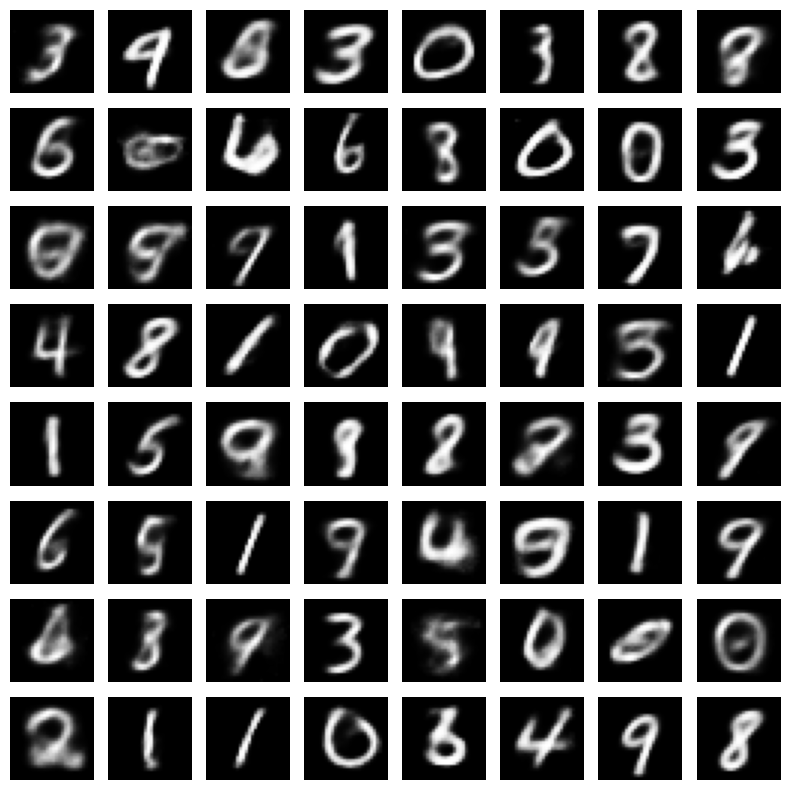

In [5]:
row, col = 8, 8

with torch.inference_mode():
    sample = (
        vae["decoder"](dist_prior.rsample((row * col,)))
        .view(-1, 28, 28, 1)
        .cpu()
        .sigmoid()
        .numpy()
    )

fig, axs = plt.subplots(row, col, constrained_layout=True, figsize=(8, 8))
k = 0
for i in range(row):
    for j in range(col):
        axs[i][j].axis("off")
        axs[i][j].imshow(sample[k], cmap="gray")
        k += 1
fig.tight_layout()
fig.savefig("beta-vae-sample.pdf")

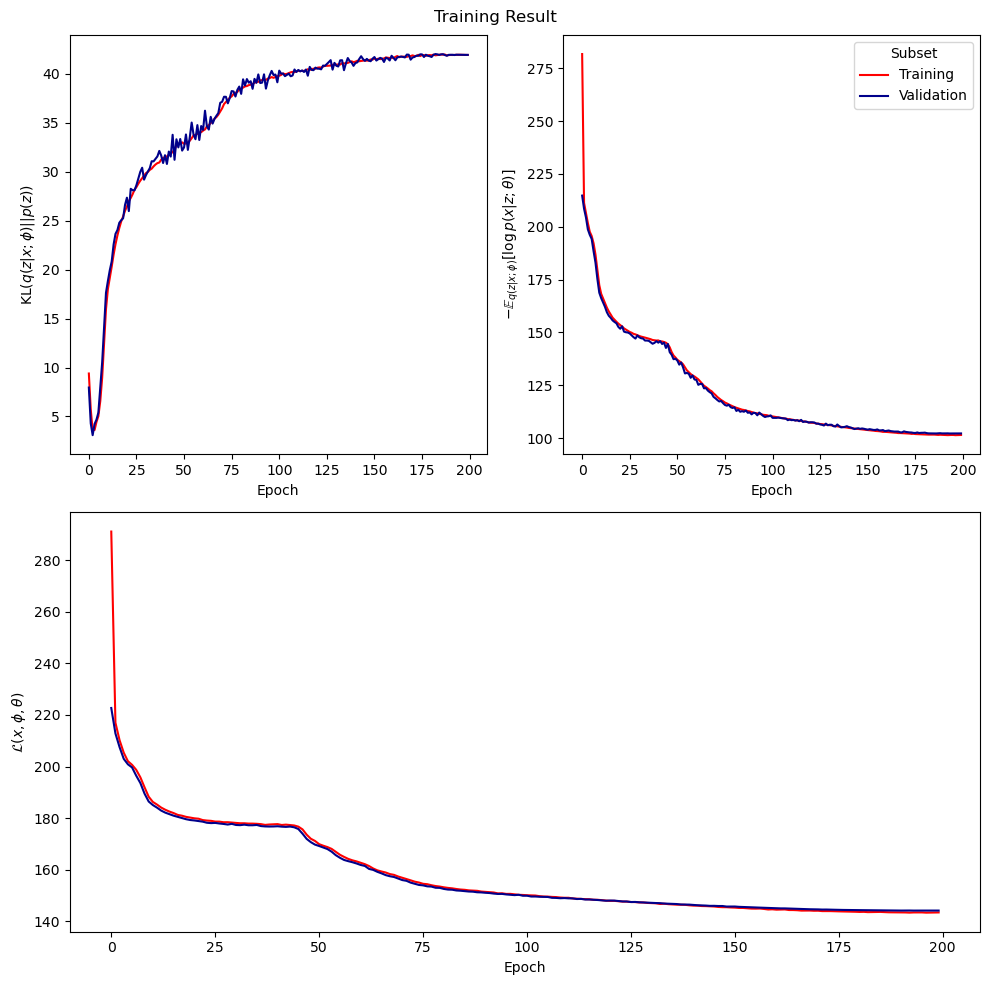

In [6]:
df = pd.DataFrame(history)

df_train = df[[key for key in df.columns if "train" in key]]
df_valid = df[[key for key in df.columns if "valid" in key]]

df_train = df_train / len(dataset["train"])
df_valid = df_valid / len(dataset["test"])

fig = plt.figure(figsize=(10, 10))

fig.suptitle("Training Result")

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 1, 2)

ax1.set_xlabel("Epoch")
ax1.set_ylabel("$\mathrm{KL}(q(z|x;\phi)||p(z))$")

ax1.plot(df_train["train_kl_div"], "-", color="red", label="Training")
ax1.plot(df_valid["valid_kl_div"], "-", color="darkblue", label="Validation")

ax2.set_xlabel("Epoch")
ax2.set_ylabel("$-\mathbb{E}_{q(z|x;\phi)}[\log p(x|z;\\theta)]$")

ax2.plot(df_train["train_nll"], "-", color="red", label="Training")
ax2.plot(df_valid["valid_nll"], "-", color="darkblue", label="Validation")
ax2.legend(title="Subset", loc="upper right")

ax3.set_xlabel("Epoch")
ax3.set_ylabel("$\mathcal{L}(x, \phi, \\theta)$")

ax3.plot(df_train["train_total"], "-", color="red", label="Training")
ax3.plot(df_valid["valid_total"], "-", color="darkblue", label="Validation")

fig.tight_layout()
fig.savefig("beta-vae-training-log.pdf")